# 수집 방법 변경후 코드 재작성
1. 월 기준 변경
2. 디렉토리 구조 변경(월별 수집)
3. 파일 개수 최대 1000개
4. Function으로 소스 수정

In [1]:
from  konlpy.tag import Kkma, Komoran, Okt, Mecab,  Hannanum
from nltk import sent_tokenize, word_tokenize
import os
from collections  import defaultdict, Counter
from math import log2, log10
import pandas as pd
import calendar

------------------------------
### Function: 수집 파일을 Dictionary 전환
1. 입력된 월의 folder에서 파일 read 후 dictionary 자료 구조생성
2. input : 시작월, 종료월

In [2]:
def read_from_file_mon(p_star_m,p_end_m,p_list_stp_w=['증권']):
    
    #파일 경로
    base_path = '/home/hadoop/jupyternotebook/Study/GalleriaPJ/blog'
    
    #파일명 header
    p_nm_f = 'G_'
    
    
    col_blg = dict()
    
    #폴더당 read 파일 limit
    doc_lmt = 1000 
     
#     for mon in pd.date_range(start=p_star_m+'01',end=p_end_m+calendar.monthrange(p_end_m[:4],int(p_end_m[4:6]))[1]) :
    for mon in pd.date_range(start=p_star_m+'01',end=p_end_m+str(calendar.monthrange(int(p_end_m[:4]),int(p_end_m[4:6]))[1]), dtype='datatime64[ns]',freq='M') :  
        doc_cnt = 0
        real_path_detail =  'G_'+mon.strftime('%Y%m')       
        real_path = base_path +'/'+ real_path_detail

        for _ in os.listdir(real_path):
            doc_cnt +=1
            if _.startswith('.') : continue

            with open(real_path+'/'+_,"r") as fp:
        #         print(_)
                tmp_str = fp.read()
#                 if '증권' not in tmp_str : col_blg[real_path_detail+"_"+_] = tmp_str
                if not any( ele  in str(tmp_str) for ele in p_list_stp_w):col_blg[real_path_detail+"_"+_] = tmp_str
                fp.close()
            if doc_cnt >= doc_lmt: break
    return col_blg 
    

#### 2.전처리 작업

In [3]:
# 패턴 정의
from string import punctuation
import re
pattern = dict()

# 구두점
pattern1 = re.compile(r'[{0}]'.format(re.escape(punctuation)))
pattern['punc'] = pattern1
# corpus = pattern1.sub(' ',corpus)

# 불용어 : 알파베 포함
# pattern2 = re.compile(r'[A-Za-z0-9]{7,}')
# pattern['stop'] = pattern2
# corpus = pattern2.sub(' ',corpus)

# 이메일
# pattern3 = re.compile(r'\w{2,}@\w{3,}(.\w{2,})+')
pattern3 = re.compile(r'\w{2,}@(.?\w{2,})+')
pattern['email'] = pattern3
# corpus = pattern3.sub(' ',corpus)

# 도메인
pattern4 = re.compile(r'(.?\w{2,}){2,}')
pattern['url'] = pattern4
# corpus = pattern4.sub(' ',corpus)

# 한글 이외
pattern5 = re.compile(r'[^가-힣0-9]+')
pattern['nonkorean'] = pattern5
# corpus = pattern5.sub(' ',corpus)

# WhiteSpace
pattern6 = re.compile(r"\s{2,}")
pattern['whitespace'] = pattern5
# corpus = pattern6.sub(' ',corpus)


#Business Stop Word
bisstop_word = ['갤러리아', '백화점', '블로그', '이전','로그인','댓글','블로거']



### 불용어 제거 Function

In [4]:
def stopword_replace(stopw, str):
    for _ in stopw:
        str = re.compile(_).sub(" ",str)
    return str

----------------------------------------
### Funtion: 형태소 분석
1. input : Dictionary{문서명,문서내용)
2. output: dictionary{문서명,{token,morpheme}}
3. 형태소 명사형만 추출

<img src="./image/morphe.jpg" width='600' height='200' align='left'>

In [5]:
from  konlpy.tag import Kkma, Komoran, Okt, Mecab, Hannanum

def mopheme_collection(col,p_moh='kom'):
    
    clct = defaultdict(lambda:defaultdict(int))
    
    if p_moh == 'kom':
        ma = Komoran()
    elif p_moh == 'okt':
        ma = Okt()
    elif p_moh == 'mec':
        ma = Mecab()
    elif p_moh == 'Han':
        ma = Hannanum()
    else: 
        ma = Kkma()
    
#     clct = col.copy()
    
    
    
    for idx, content in col.items():
        
        indexTerm_content = defaultdict(int)
        # 패턴 전치리
        ## 불용어 제거
        content = stopword_replace(bisstop_word,content)
        
        for _ in ['email','punc', 'whitespace']:
            content_pth = pattern[_].sub(" ", content)
        for tokens in word_tokenize(content_pth) :        
            for term_pos in ma.pos(tokens) :
#                 if len(term_pos[0]) > 1 and term_pos[1].startswith("N") :
#                   if len(term_pos[0]) > 1 and term_pos[1].startswith("N") :
                  if len(term_pos[0]) > 1 and term_pos[1].startswith("N") :
                      indexTerm_content[term_pos[0]] +=1
                      #ngram 사용시 아래 적용
#                     for n in ngram(term_pos[0]):
#                         indexTerm_content[n] +=1
         
        clct[idx] = indexTerm_content  
        
   
    return clct

In [13]:
from konlpy.tag import Hannanum ,Kkma, Komoran, Twitter,Okt
# Komoran().tagset
Okt().tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

---------------------------------------------
### Functoin: 토큰별 카운트 
1. input : dict{docname,dict{lexicon,morphemem}}
2. output: Counter(lexicon,count)

In [6]:
def lexicon_counter(mor_col):
    cnt_lexicon = Counter()
    for _ in mor_col.values() :
        cnt_lexicon += Counter(_)
    return cnt_lexicon

----------------------------------------------------
### Function : Dictionary 에서 입력 word 포함 문서 명 찾기
1. input : dic{file_name:dic{token,morpheme}}
2. output: file name list

In [7]:

# 입력 된 단어가 들어가 문서 찾기
def find_fileName_word(p_dic,f_wd):
    base_url = 'https://blog.naver.com/PostView.nhn?blogId={0}&logNo={1}&redirect=Dlog&widgetTypeCall=true&directAccess=false'
    file_list = []

    for _ in p_dic.items():
        fileName = _[0]
        linK_url = "" if len(fileName.split('_')) < 4 else base_url.format(fileName.split('_')[2],fileName.split('_')[3])
        if f_wd in _[1].keys(): file_list.append(fileName+': '+linK_url)
    return file_list



--------------------------------
### Function : input word가 있는 문서 내용 출력
1. input : dic{file_name,document},dic{file_name,{token,morpheme}), token, print_max_doc
2. output : document

In [8]:

# 입력 된 단어가 들어간 문서 print
def print_doc_word(dic_doc,dic_token, f_wd, m_cnt=3):
    file_list = []
    rd_cnt = 0
    
    
    file_list = find_fileName_word(dic_token,f_wd)
    
    for _ in file_list:
        print('----------------------------------------')
        print('---------'+ _ +'----------')
        print(dic_doc[_.split(':')[0]])    
        rd_cnt +=1
        
        if rd_cnt == m_cnt :return
   

### 분석 Fun 호출

In [9]:
# 파일 읽기
dic_doc = read_from_file_mon('201901','201901')
# 형태소 분석
dic_morph = mopheme_collection(dic_doc)
# 형태소 별 카운트
cnt_lexicon = lexicon_counter(dic_morph)

In [10]:
cnt_lexicon.most_common(20)

[('공지', 3312),
 ('제한', 2983),
 ('이동', 2444),
 ('상단', 2288),
 ('화면', 2287),
 ('목록', 2081),
 ('글쓰기', 1968),
 ('헤어', 1884),
 ('공감', 1698),
 ('작성', 1626),
 ('추천', 1576),
 ('아파트', 1566),
 ('다음', 1471),
 ('사용', 1455),
 ('메뉴', 1448),
 ('상가', 1407),
 ('천안', 1373),
 ('제목', 1364),
 ('사진', 1355),
 ('확인', 1311)]

### Word Cloud

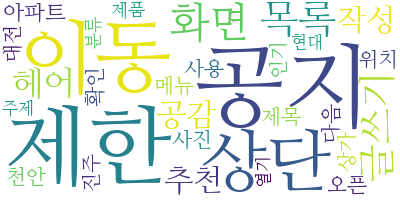

In [12]:
from wordcloud import WordCloud
font ="/usr/share/fonts/NanumFont/NanumMyeongjo.ttf"
wc = WordCloud(font_path=font, max_words=30, background_color='white')
wc.generate_from_frequencies(cnt_lexicon)
wc.to_image()

In [13]:
print('문서수:{0}/카운트:{1}'.format(str(len(find_fileName_word(dic_morph,'공지'))),cnt_lexicon['공지']))
find_fileName_word(dic_morph,'공지')
# print_doc_word(dic_doc,dic_morph,'공지',2)
# cnt_lexicon['헤어']
# print('천안:{0}'.format(str(len(find_fileName_word(dic_morph,'천안')))))
# print_doc_word(dic_doc,dic_morph,'천안',2)

문서수:982/카운트:3312


['G_201901_nanast1004_221439970996: https://blog.naver.com/PostView.nhn?blogId=nanast1004&logNo=221439970996&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_flyyj1_221435582796: https://blog.naver.com/PostView.nhn?blogId=flyyj1&logNo=221435582796&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_seeyou1991_221439879626: https://blog.naver.com/PostView.nhn?blogId=seeyou1991&logNo=221439879626&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_mj6212_221437411189: https://blog.naver.com/PostView.nhn?blogId=mj6212&logNo=221437411189&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_helphelpsos_221431679769: https://blog.naver.com/PostView.nhn?blogId=helphelpsos&logNo=221431679769&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_mamaison__221432492595: https://blog.naver.com/PostView.nhn?blogId=mamaison&logNo=&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_eyedear84_221435469325: https://bl

------------------------------------------
## TF-IDF(Term Frequency - Inverse Document Frequency) 기준 재선정
<font size ='5'>
1. I love dogs.
<br>
2. I hate dogs and knitting.
<br>
3. Knitting is my hobby and my passion.
</font>
<br>
<img src="./image/TF_Formula.png" width='400' height='400' align='left'/>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<img src="./image/TF_IDF.jpg" width='800' height='400' align='left'/>


In [14]:
from math import sqrt

def TF_IDF(dic_doc_token):
    DTM = defaultdict(lambda:defaultdict(int))
    TDM = defaultdict(lambda:defaultdict(int))
    TWM = defaultdict(lambda:defaultdict(int))
    DVL = defaultdict(float)
    #DTM
    for idx, termList in dic_doc_token.items():
        for term, freq in termList.items():
            DTM[idx][term] = freq

    #TDM
    for idx, termList in DTM.items():
        for term, freq in termList.items():
            TDM[term][idx] = freq

    # 문서 개수
    N = len(DTM)

    #TWM
    for idx, termList in DTM.items():
        maxTF = max(termList.values())

        for term, freq in termList.items():

            TF = freq/maxTF
            IDF =  log10(N/len(TDM[term]))

            TWM[term][idx] = TF*IDF
            DVL[idx] += TWM[term][idx]**2
    return TWM

-----------------------------------
### Function : TF-IDF token별 가중치 합계 
1. input: dic{doc_name:dic{token,mopheme}}
2. output: TWC = Counter(token:Weight Sum)

In [15]:
import math
def TF_IDF_SUM(dic_TWM):
    TWC = defaultdict(float) 

    for term, WM in dic_TWM.items():
        tmp_sum = math.fsum(WM.values()) 
        TWC[term] = tmp_sum
#     print(term + " : "+ str(tmp_sum))
    return Counter(TWC)  

In [16]:
dic_201901_TFIDF = TF_IDF(dic_morph)
dic_201901_TFIDF_CNT = TF_IDF_SUM(dic_201901_TFIDF)

In [17]:
dic_201901_TFIDF_CNT.most_common(30)

[('광교', 50.25130733261796),
 ('천안', 47.96788484685581),
 ('대전', 47.62420833531544),
 ('부동산', 44.72848679593776),
 ('진주', 42.69445090046049),
 ('아파트', 41.665870209561405),
 ('세일', 41.12247193627393),
 ('불가', 40.895528957549836),
 ('오피스텔', 35.95787370930238),
 ('제품', 35.16035861653849),
 ('분양', 35.075697838934225),
 ('프라이스', 34.7599103787981),
 ('판매', 33.70094527312659),
 ('사용', 33.41873986511833),
 ('여행', 33.228286714296274),
 ('수원', 32.95497442567925),
 ('상가', 32.6630053410583),
 ('매장', 32.24385189302598),
 ('상품권', 31.094163664714586),
 ('할인', 30.900893874865623),
 ('사진', 30.576437131831312),
 ('둔산동', 30.525823607033775),
 ('브랜드', 30.477749635827006),
 ('하이퍼', 30.35015239980448),
 ('번개', 30.161500030165897),
 ('장터', 29.735183689579976),
 ('맛집', 29.19637092371764),
 ('압구정', 27.84572895248876),
 ('카페', 27.73419107272283),
 ('구매', 27.595044749739618)]

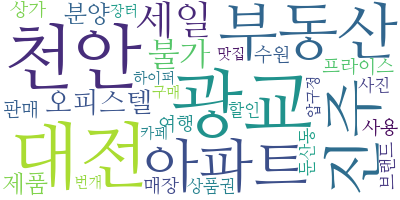

In [18]:
wc.generate_from_frequencies(dic_201901_TFIDF_CNT)
wc.to_image()

In [34]:
print(len(find_fileName_word(dic_morph,'하이퍼')))
find_fileName_word(dic_morph,'하이퍼')
# dic_201901_TFIDF['불가']


28


['G_201901_hyperprice_221442838428: https://blog.naver.com/PostView.nhn?blogId=hyperprice&logNo=221442838428&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_hyperprice_221439270959: https://blog.naver.com/PostView.nhn?blogId=hyperprice&logNo=221439270959&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_hyperprice_221440947166: https://blog.naver.com/PostView.nhn?blogId=hyperprice&logNo=221440947166&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_hyperprice_221440114861: https://blog.naver.com/PostView.nhn?blogId=hyperprice&logNo=221440114861&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_hyperprice_221434299543: https://blog.naver.com/PostView.nhn?blogId=hyperprice&logNo=221434299543&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_hyperprice_221441106093: https://blog.naver.com/PostView.nhn?blogId=hyperprice&logNo=221441106093&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_hyper

---------------------------------------
#### Function : 문서별 TF-IDF 지수가 큰 Token n개 추출
1. input : dic(TF-IDF), 추출 token
2. output : Counter

In [20]:
from heapq import nlargest

def TF_IDF_MAX_SEL(d_TFIDF,n_cnt):
    # TF_IDF를 token 기준 변경
    DWM = defaultdict(lambda:defaultdict(int))
    for wd,dw in d_TFIDF.items():
        for filname, w in dw.items():
            DWM[filname][wd] = w
    n_large_Cnt = Counter()
    
    for index, WM in DWM.items():
        n_lar = nlargest(n_cnt,WM, key=WM.get)
        n_large_Cnt +=Counter(n_lar)
    return n_large_Cnt 

In [21]:
cnt_TFIDF_Max_N = TF_IDF_MAX_SEL(dic_201901_TFIDF,10)
cnt_TFIDF_Max_N.most_common(100)

[('천안', 53),
 ('대전', 48),
 ('광교', 45),
 ('아파트', 40),
 ('진주', 38),
 ('수원', 37),
 ('세일', 37),
 ('부동산', 36),
 ('오피스텔', 35),
 ('상가', 34),
 ('둔산동', 33),
 ('분양', 31),
 ('매매', 28),
 ('프라이스', 28),
 ('하이퍼', 28),
 ('번개', 27),
 ('장터', 27),
 ('공인중개사', 26),
 ('인계동', 25),
 ('매물', 24),
 ('연락', 24),
 ('상품권', 23),
 ('압구정', 22),
 ('전세', 22),
 ('옥션', 21),
 ('플리', 20),
 ('원룸', 20),
 ('맛집', 20),
 ('청담동', 20),
 ('퍼스', 19),
 ('수플레', 19),
 ('패션', 19),
 ('피부', 19),
 ('하임', 19),
 ('케익', 18),
 ('뷰어', 18),
 ('청담', 18),
 ('시티', 17),
 ('클래스', 17),
 ('단지', 17),
 ('카페', 17),
 ('불당동', 16),
 ('시계', 16),
 ('여행', 16),
 ('일본', 15),
 ('신축', 15),
 ('공간', 15),
 ('할인', 15),
 ('교환', 15),
 ('번역', 15),
 ('아산', 15),
 ('현대', 14),
 ('세대', 14),
 ('거실', 13),
 ('식당', 13),
 ('카드', 13),
 ('상권', 13),
 ('사무소', 13),
 ('꽃집', 13),
 ('제품', 13),
 ('롤렉스', 13),
 ('빌라', 13),
 ('천안아산역', 13),
 ('코트', 13),
 ('컬러', 12),
 ('행복', 12),
 ('샤넬', 12),
 ('매출', 12),
 ('명언', 12),
 ('매입', 12),
 ('월세', 12),
 ('이벤트', 12),
 ('헤어', 12),
 ('구찌', 12),
 ('슈츠', 12),
 

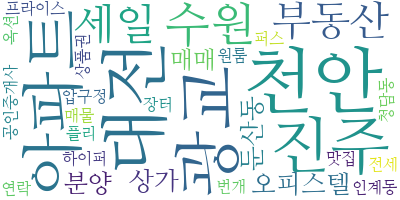

In [22]:
wc.generate_from_frequencies(cnt_TFIDF_Max_N)
wc.to_image()

In [23]:
print(len(find_fileName_word(dic_morph,'퍼스')))
find_fileName_word(dic_morph,'퍼스')

22


['G_201901_seeyou1991_221439879626: https://blog.naver.com/PostView.nhn?blogId=seeyou1991&logNo=221439879626&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_kl36521_221440968077: https://blog.naver.com/PostView.nhn?blogId=kl36521&logNo=221440968077&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_ssu081218_221439828024: https://blog.naver.com/PostView.nhn?blogId=ssu081218&logNo=221439828024&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_ma0138_221438361582: https://blog.naver.com/PostView.nhn?blogId=ma0138&logNo=221438361582&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_pinkaru0530_221438879518: https://blog.naver.com/PostView.nhn?blogId=pinkaru0530&logNo=221438879518&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_dnldend_221441240476: https://blog.naver.com/PostView.nhn?blogId=dnldend&logNo=221441240476&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_mjkim031307_221437414625:

----------------------------------
#### 형태소 분석기별 성능 분석

In [270]:
import timeit


s_time = timeit.default_timer()

# 형태소 분석
dic_morph_kom = mopheme_collection(dic_doc,'kom')
kom_time = timeit.default_timer()
print('형태소분석(komoran):'+str(kom_time - s_time))

dic_morph_okt = mopheme_collection(dic_doc,'okt')
okt_time = timeit.default_timer()
print('형태소분석(Okt):'+str(okt_time - kom_time))

dic_morph_han = mopheme_collection(dic_doc,'han')
han_time = timeit.default_timer()
print('형태소분석(Hannanum):'+str(han_time - okt_time ))

dic_morph_kkm = mopheme_collection(dic_doc,'kkm')
kkm_time = timeit.default_timer()
print('형태소분석(Kkoma):'+str(kkm_time - han_time))

dic_morph_mec = mopheme_collection(dic_doc,'mec')
mec_time = timeit.default_timer()
print('형태소분석(Mecab):'+str(mec_time - kkm_time))

# TF_IDF
dic_TFIDF_kom = TF_IDF(dic_morph_kom)
print('TF_IDF(komoran) 완료')

dic_TFIDF_okt = TF_IDF(dic_morph_okt)
print('TF_IDF(Okt) 완료')

dic_TFIDF_kkm = TF_IDF(dic_morph_kkm)
print('TF_IDF(Kkma) 완료')

dic_TFIDF_han = TF_IDF(dic_morph_han)
print('TF_IDF(hananum) 완료')

dic_TFIDF_mec = TF_IDF(dic_morph_mec)
print('TF_IDF(Mecab) 완료')

print('총소요 시간:'+str(timeit.default_timer() - s_time))


형태소분석(komoran):261.03661683599057
형태소분석(Okt):305.57501176600636
형태소분석(Hannanum):2557.292773676003
형태소분석(Kkoma):2554.7116950279888
형태소분석(Mecab):27.80562457900669
TF_IDF(komoran) 완료
TF_IDF(Okt) 완료
TF_IDF(Kkma) 완료
TF_IDF(hananum) 완료
TF_IDF(Mecab) 완료
총소요 시간:5710.449722984995


In [201]:
# TF_IDF MAX 카운트 
dic_TFIDF_CNT_kom = TF_IDF_MAX_SEL(dic_TFIDF_kom,20)
dic_TFIDF_CNT_okt = TF_IDF_MAX_SEL(dic_TFIDF_okt,20)
dic_TFIDF_CNT_kkm = TF_IDF_MAX_SEL(dic_TFIDF_kkm,20)
dic_TFIDF_CNT_han = TF_IDF_MAX_SEL(dic_TFIDF_han,20)
dic_TFIDF_CNT_mec = TF_IDF_MAX_SEL(dic_TFIDF_mec,20)

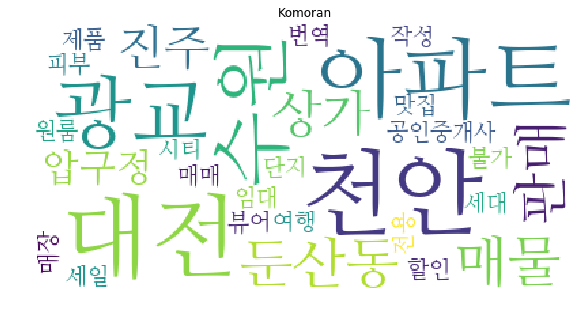

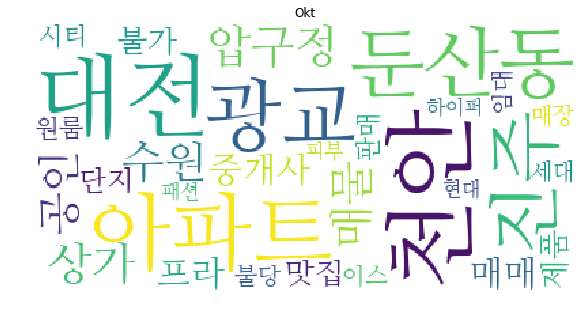

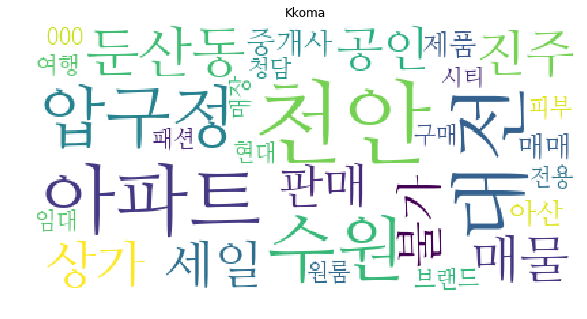

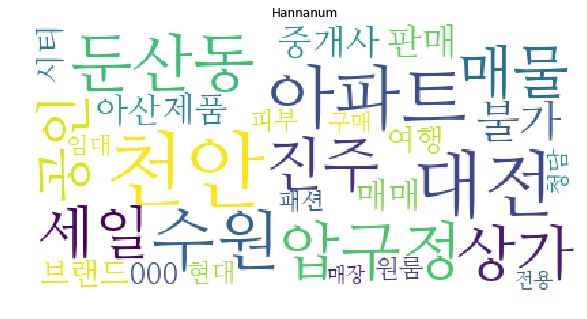

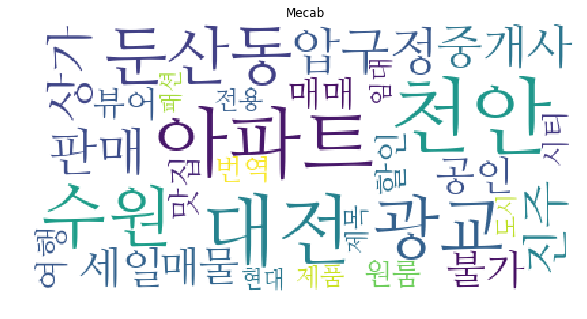

In [202]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] =(10,5)

wc.generate_from_frequencies(dic_TFIDF_CNT_kom)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('Komoran')
plt.show()

wc.generate_from_frequencies(dic_TFIDF_CNT_okt)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('Okt')
plt.show()

wc.generate_from_frequencies(dic_TFIDF_CNT_kkm)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('Kkoma')
plt.show()


wc.generate_from_frequencies(dic_TFIDF_CNT_han)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('Hannanum')
plt.show()


wc.generate_from_frequencies(dic_TFIDF_CNT_mec)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('Mecab')
plt.show()

In [224]:
import pandas as pd
# df = pd.DataFrame(columns=['a','b','c','d'])

# df = pd.DataFrame.from_dict(dic_TFIDF_CNT_han.most_common(10), orient='index').reset_index()
df = pd.DataFrame(
{'Kom':dic_TFIDF_CNT_kom.most_common(20),
 'Okt':dic_TFIDF_CNT_okt.most_common(20),
 'Han':dic_TFIDF_CNT_han.most_common(20),
 'Kkm':dic_TFIDF_CNT_kkm.most_common(20),
 'mec':dic_TFIDF_CNT_mec.most_common(20)
})
df

,Kom,Okt,Han,Kkm,mec
0,"(천안, 72)","(천안, 72)","(천안, 87)","(천안, 87)","(천안, 81)"
1,"(대전, 65)","(대전, 65)","(대전, 68)","(대전, 68)","(대전, 68)"
2,"(아파트, 61)","(아파트, 56)","(아파트, 60)","(아파트, 60)","(아파트, 65)"
3,"(광교, 49)","(광교, 49)","(수원, 52)","(수원, 52)","(광교, 51)"
4,"(수원, 48)","(둔산동, 47)","(압구정, 48)","(압구정, 48)","(수원, 50)"
5,"(둔산동, 46)","(진주, 43)","(둔산동, 48)","(둔산동, 48)","(둔산동, 48)"
6,"(매물, 45)","(압구정, 42)","(상가, 44)","(상가, 44)","(압구정, 46)"
7,"(판매, 45)","(상가, 42)","(진주, 43)","(진주, 43)","(판매, 46)"
8,"(상가, 44)","(매물, 41)","(매물, 42)","(매물, 42)","(진주, 44)"
9,"(진주, 42)","(수원, 39)","(세일, 42)","(세일, 42)","(상가, 43)"


-------------------------
#### 부동산 관련 문제 제외

In [24]:
# 부동산 관련 문서 제외 read
lis_stop_wrd = ['증권','부동산','분양','오피스텔','전세','월세','상가','임대','매매','중개사']
dic_doc_not_estate = read_from_file_mon('201901','201901',lis_stop_wrd)
dic_morph_not_estate = mopheme_collection(dic_doc_not_estate,'mec')
dic_TFIDF_not_estate = TF_IDF(dic_morph_not_estate)
cnt_TFIDF_SUM_not_estate = TF_IDF_SUM(dic_TFIDF_not_estate)
cnt_TFIDF_MAX_not_estate = TF_IDF_MAX_SEL(dic_TFIDF_not_estate,30)

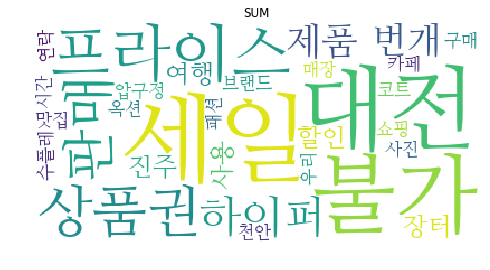

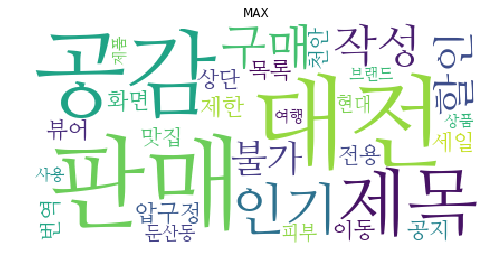

In [28]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] =(8,5)

wc.generate_from_frequencies(cnt_TFIDF_SUM_not_estate)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('SUM')
plt.show()

wc.generate_from_frequencies(cnt_TFIDF_MAX_not_estate)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('MAX')
plt.show()

In [29]:
# wc.generate_from_frequencies(cnt_TFIDF_MAX_not_estate)
# wc.to_image()
# cnt_TFIDF_MAX_not_estate.most_common(100)
cnt_TFIDF_SUM_not_estate.most_common(50)

[('세일', 36.10720837176934),
 ('대전', 32.46912000076244),
 ('불가', 31.63652752625814),
 ('프라이스', 31.12038698156384),
 ('상품권', 28.631272887867656),
 ('판매', 27.475883371676396),
 ('하이퍼', 27.252435975108526),
 ('제품', 25.97844607515032),
 ('번개', 25.756778995778095),
 ('여행', 25.6973356727604),
 ('장터', 25.45112906151624),
 ('사용', 24.90005680287418),
 ('진주', 23.81955611023939),
 ('할인', 23.400115938474663),
 ('압구정', 23.08256735479234),
 ('매장', 22.966678657305536),
 ('브랜드', 22.934252913620472),
 ('옥션', 22.83156176209065),
 ('사진', 22.622383975366052),
 ('구매', 22.470069400544876),
 ('맛집', 22.26882303202713),
 ('천안', 22.128851190168238),
 ('수플레', 21.709209415842594),
 ('연락', 21.64117729290339),
 ('쇼핑', 21.599512329642682),
 ('카페', 21.473011666796268),
 ('코트', 20.93534930704851),
 ('우리', 20.300870128976293),
 ('패션', 20.233622440007117),
 ('시간', 20.21833304554751),
 ('플리퍼스', 19.99180833134773),
 ('일상', 19.424445458634693),
 ('생각', 19.31747360362733),
 ('선물', 19.197502384515282),
 ('저작', 18.970909880299

In [35]:
find_fileName_word(dic_morph_not_estate,'하이퍼')
# dic_TFIDF_not_estate['옥션']
# cnt_TFIDF_MAX_not_estate['옥션']

['G_201901_hyperprice_221442838428: https://blog.naver.com/PostView.nhn?blogId=hyperprice&logNo=221442838428&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_hyperprice_221439270959: https://blog.naver.com/PostView.nhn?blogId=hyperprice&logNo=221439270959&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_hyperprice_221440947166: https://blog.naver.com/PostView.nhn?blogId=hyperprice&logNo=221440947166&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_hyperprice_221440114861: https://blog.naver.com/PostView.nhn?blogId=hyperprice&logNo=221440114861&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_hyperprice_221434299543: https://blog.naver.com/PostView.nhn?blogId=hyperprice&logNo=221434299543&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_hyperprice_221441106093: https://blog.naver.com/PostView.nhn?blogId=hyperprice&logNo=221441106093&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201901_hyper

----------------------------------
### 월별 조회
1. 부동산 관련 문서 제외
2. 형태소 분석기 : 은전 한닢(Mecab) 사용
3. TF_IDF의 Weight Sum기준 추출.

In [30]:
# stop word 정의
lis_stop_wrd = ['증권','부동산','분양','오피스텔','전세','월세','상가','임대','매매','중개사']

# 문서 읽기
dic_doc_201901 = read_from_file_mon('201901','201901',lis_stop_wrd)
dic_doc_201902 = read_from_file_mon('201902','201902',lis_stop_wrd)
dic_doc_201903 = read_from_file_mon('201903','201903',lis_stop_wrd)
dic_doc_201904 = read_from_file_mon('201904','201904',lis_stop_wrd)
dic_doc_201905 = read_from_file_mon('201905','201905',lis_stop_wrd)
dic_doc_201906 = read_from_file_mon('201906','201906',lis_stop_wrd)
dic_doc_201907 = read_from_file_mon('201907','201907',lis_stop_wrd)
dic_doc_201908 = read_from_file_mon('201908','201908',lis_stop_wrd)
dic_doc_201909 = read_from_file_mon('201909','201909',lis_stop_wrd)
dic_doc_201910 = read_from_file_mon('201910','201910',lis_stop_wrd)
dic_doc_201911 = read_from_file_mon('201911','201911',lis_stop_wrd)
dic_doc_201912 = read_from_file_mon('201912','201912',lis_stop_wrd)
print('파일 Read 완료')

# 형태소분석
dic_morph_201901 = mopheme_collection(dic_doc_201901,'mec')
dic_morph_201902 = mopheme_collection(dic_doc_201902,'mec')
dic_morph_201903 = mopheme_collection(dic_doc_201903,'mec')
dic_morph_201904 = mopheme_collection(dic_doc_201904,'mec')
dic_morph_201905 = mopheme_collection(dic_doc_201905,'mec')
dic_morph_201906 = mopheme_collection(dic_doc_201906,'mec')
dic_morph_201907 = mopheme_collection(dic_doc_201907,'mec')
dic_morph_201908 = mopheme_collection(dic_doc_201908,'mec')
dic_morph_201909 = mopheme_collection(dic_doc_201909,'mec')
dic_morph_201910 = mopheme_collection(dic_doc_201910,'mec')
dic_morph_201911 = mopheme_collection(dic_doc_201911,'mec')
dic_morph_201912 = mopheme_collection(dic_doc_201912,'mec')
print('형태소 분석완료')

#TF_IDF
dic_TFIDF_201901 = TF_IDF(dic_morph_201901)
dic_TFIDF_201902 = TF_IDF(dic_morph_201902)
dic_TFIDF_201903 = TF_IDF(dic_morph_201903)
dic_TFIDF_201904 = TF_IDF(dic_morph_201904)
dic_TFIDF_201905 = TF_IDF(dic_morph_201905)
dic_TFIDF_201906 = TF_IDF(dic_morph_201906)
dic_TFIDF_201907 = TF_IDF(dic_morph_201907)
dic_TFIDF_201908 = TF_IDF(dic_morph_201908)
dic_TFIDF_201909 = TF_IDF(dic_morph_201909)
dic_TFIDF_201910 = TF_IDF(dic_morph_201910)
dic_TFIDF_201911 = TF_IDF(dic_morph_201911)
dic_TFIDF_201912 = TF_IDF(dic_morph_201912)
print('TF_IDF 완료')


# TF_IDF_SUM
cnt_TFIDF_SUM_201901 = TF_IDF_SUM(dic_TFIDF_201901)
cnt_TFIDF_SUM_201902 = TF_IDF_SUM(dic_TFIDF_201902)
cnt_TFIDF_SUM_201903 = TF_IDF_SUM(dic_TFIDF_201903)
cnt_TFIDF_SUM_201904 = TF_IDF_SUM(dic_TFIDF_201904)
cnt_TFIDF_SUM_201905 = TF_IDF_SUM(dic_TFIDF_201905)
cnt_TFIDF_SUM_201906 = TF_IDF_SUM(dic_TFIDF_201906)
cnt_TFIDF_SUM_201907 = TF_IDF_SUM(dic_TFIDF_201907)
cnt_TFIDF_SUM_201908 = TF_IDF_SUM(dic_TFIDF_201908)
cnt_TFIDF_SUM_201909 = TF_IDF_SUM(dic_TFIDF_201909)
cnt_TFIDF_SUM_201910 = TF_IDF_SUM(dic_TFIDF_201910)
cnt_TFIDF_SUM_201911 = TF_IDF_SUM(dic_TFIDF_201911)
cnt_TFIDF_SUM_201912 = TF_IDF_SUM(dic_TFIDF_201912)
print('TF_IDF Sum 완료')


파일 Read 완료
형태소 분석완료
TF_IDF 완료
TF_IDF Sum 완료


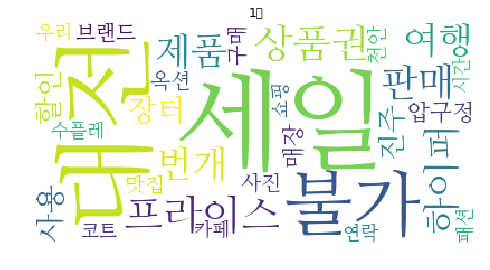

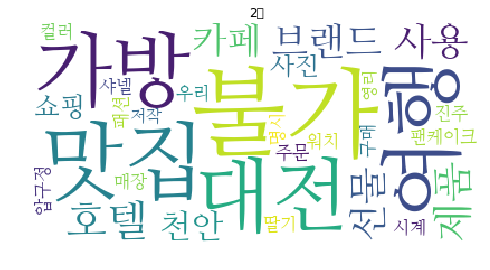

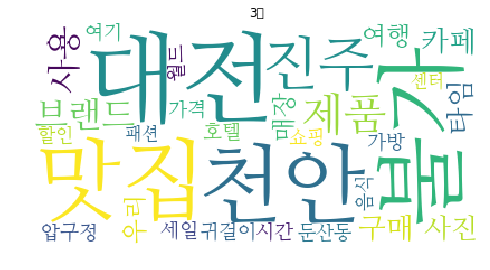

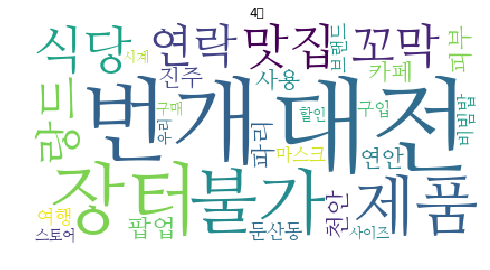

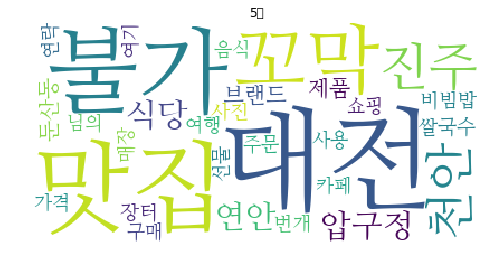

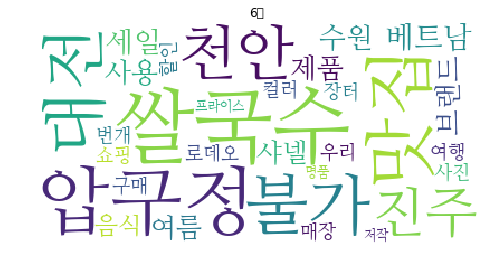

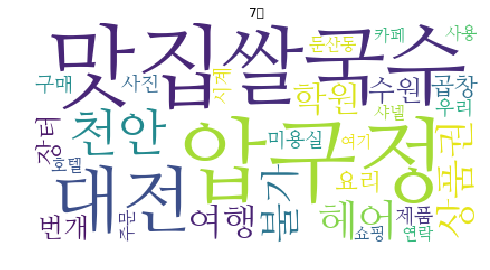

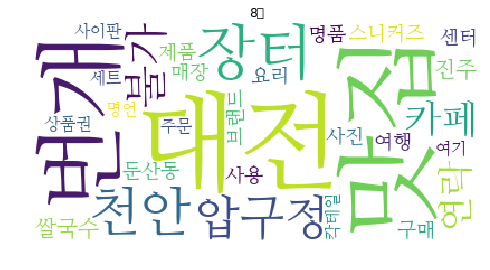

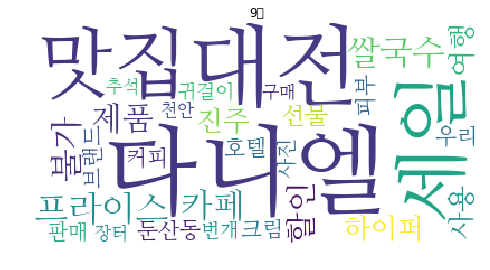

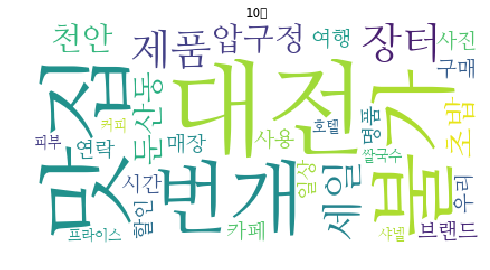

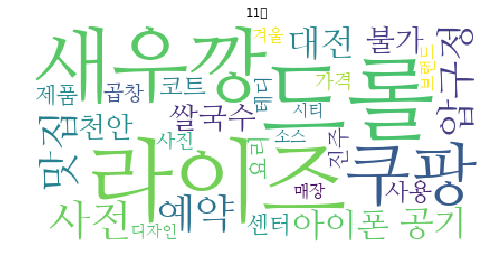

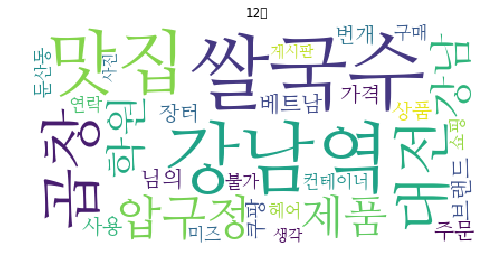

In [31]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] =(8,8)

wc.generate_from_frequencies(cnt_TFIDF_SUM_201901)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('1월')
plt.show()

wc.generate_from_frequencies(cnt_TFIDF_SUM_201902)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('2월')
plt.show()

wc.generate_from_frequencies(cnt_TFIDF_SUM_201903)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('3월')
plt.show()


wc.generate_from_frequencies(cnt_TFIDF_SUM_201904)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('4월')
plt.show()


wc.generate_from_frequencies(cnt_TFIDF_SUM_201905)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('5월')
plt.show()


wc.generate_from_frequencies(cnt_TFIDF_SUM_201906)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('6월')
plt.show()

wc.generate_from_frequencies(cnt_TFIDF_SUM_201907)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('7월')
plt.show()

wc.generate_from_frequencies(cnt_TFIDF_SUM_201908)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('8월')
plt.show()

wc.generate_from_frequencies(cnt_TFIDF_SUM_201909)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('9월')
plt.show()

wc.generate_from_frequencies(cnt_TFIDF_SUM_201910)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('10월')
plt.show()


wc.generate_from_frequencies(cnt_TFIDF_SUM_201911)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('11월')
plt.show()

wc.generate_from_frequencies(cnt_TFIDF_SUM_201912)
plt.imshow(wc.to_array())
plt.axis('off')
plt.title('12월')
plt.show()

In [32]:
import pandas as pd
df = pd.DataFrame(
{'01월':cnt_TFIDF_SUM_201901.most_common(20),
 '02월':cnt_TFIDF_SUM_201902.most_common(20),
 '03월':cnt_TFIDF_SUM_201903.most_common(20),
 '04월':cnt_TFIDF_SUM_201904.most_common(20),
 '05월':cnt_TFIDF_SUM_201905.most_common(20),
 '06월':cnt_TFIDF_SUM_201906.most_common(20),
 '07월':cnt_TFIDF_SUM_201907.most_common(20),
 '08월':cnt_TFIDF_SUM_201908.most_common(20),
 '09월':cnt_TFIDF_SUM_201909.most_common(20),
 '10월':cnt_TFIDF_SUM_201910.most_common(20),
 '11월':cnt_TFIDF_SUM_201911.most_common(20),
 '12월':cnt_TFIDF_SUM_201912.most_common(20)
})
df

,01월,02월,03월,04월,05월,06월,07월,08월,09월,10월,11월,12월
0,"(세일, 36.10720837176934)","(불가, 36.028331286878846)","(대전, 35.06031217345464)","(대전, 42.50065296584322)","(대전, 46.62966837797343)","(쌀국수, 49.41486255491393)","(압구정, 58.744655393379496)","(대전, 45.796064960465884)","(다니엘, 53.589656697679615)","(대전, 43.51412922104715)","(드롤, 48.24097589136011)","(쌀국수, 63.934221679969184)"
1,"(대전, 32.46912000076244)","(맛집, 27.30743588239352)","(불가, 30.409519913459206)","(번개, 33.88715448183354)","(맛집, 35.32763659933679)","(압구정, 45.300299690000394)","(맛집, 57.796421806356605)","(맛집, 45.255248422053434)","(대전, 44.49184132376643)","(맛집, 36.89686796333694)","(라이즈, 48.24097589136011)","(강남역, 59.58744877266644)"
2,"(불가, 31.63652752625814)","(여행, 26.655148085172396)","(맛집, 27.87256009526009)","(장터, 33.757051482267144)","(불가, 31.045542612715344)","(맛집, 42.4224100671481)","(쌀국수, 53.28922850838244)","(번개, 33.85882287340886)","(맛집, 32.932373097669)","(불가, 29.64648036754903)","(새우깡, 48.22046346167402)","(맛집, 49.55528421111752)"
3,"(프라이스, 31.12038698156384)","(가방, 26.50505397749287)","(천안, 27.38654912862678)","(불가, 31.9989465707175)","(꼬막, 30.807521551804527)","(대전, 35.370336221502505)","(대전, 37.710789810608595)","(장터, 33.6004788720652)","(세일, 32.55616182531887)","(번개, 29.620286735072412)","(쿠팡, 47.85747619922042)","(곱창, 37.81854178169899)"
4,"(상품권, 28.631272887867656)","(대전, 26.056174354887197)","(진주, 26.028575809841346)","(제품, 31.411240363084936)","(진주, 30.055496080540856)","(불가, 32.72287766016811)","(천안, 28.203719808759683)","(천안, 33.12541870080216)","(프라이스, 30.293170522565358)","(장터, 29.135717209876496)","(사전, 47.721588601906156)","(대전, 33.41558906989903)"
5,"(판매, 27.475883371676396)","(호텔, 25.445225069440273)","(제품, 22.81326606162011)","(식당, 31.00470957803195)","(천안, 29.46072681498974)","(천안, 28.29262566426326)","(헤어, 27.329241672615954)","(압구정, 32.95172897613015)","(불가, 29.104368851083088)","(제품, 28.77504858665048)","(맛집, 45.48387502682604)","(압구정, 26.962423965163513)"
6,"(하이퍼, 27.252435975108526)","(제품, 23.995205456818745)","(브랜드, 22.615260337096)","(맛집, 29.487957032740027)","(압구정, 27.77512903431967)","(진주, 27.26326710916102)","(상품권, 26.40432767941791)","(불가, 29.817003371168216)","(쌀국수, 28.19823097244431)","(세일, 28.528241964372533)","(예약, 43.4538205663645)","(제품, 25.883293730703407)"
7,"(제품, 25.97844607515032)","(사용, 23.728687764685596)","(사용, 22.352921814753707)","(꼬막, 27.361266277254277)","(연안, 27.406622729249992)","(베트남, 26.958318538288403)","(불가, 26.310119694233776)","(카페, 28.728155620878994)","(카페, 27.253818361922647)","(압구정, 26.60346108439243)","(압구정, 41.18557476636707)","(강남, 25.13896603551977)"
8,"(번개, 25.756778995778095)","(브랜드, 23.403579775073307)","(구매, 21.41027400920301)","(연락, 26.795222466585805)","(식당, 27.358286023600286)","(세일, 25.523504068324836)","(여행, 25.16965808406225)","(연락, 27.314048224861576)","(제품, 26.304245856857726)","(천안, 26.462891170596286)","(공기, 32.53706777517199)","(학원, 23.62379040734655)"
9,"(여행, 25.6973356727604)","(선물, 23.054454402508522)","(카페, 20.752873422777906)","(랑드, 26.55719280160617)","(브랜드, 26.06336580295199)","(수원, 23.42677266992457)","(학원, 24.75184946240079)","(쌀국수, 25.831414839686687)","(할인, 26.155491580874013)","(둔산동, 26.44398200131201)","(대전, 32.146241560223544)","(베트남, 23.496827808897)"


In [277]:
print('문서수:{0}/카운트:{1}'.format(str(len(find_fileName_word(dic_morph_201909,'다니엘'))),cnt_TFIDF_SUM_201909['다니엘']))
find_fileName_word(dic_morph_201909,'다니엘')

문서수:55/카운트:53.589656697679615


['G_201909_sdy8657_221637652773: https://blog.naver.com/PostView.nhn?blogId=sdy8657&logNo=221637652773&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201909_bom____bom_221635408068: https://blog.naver.com/PostView.nhn?blogId=bom&logNo=&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201909_topaz55_221637781253: https://blog.naver.com/PostView.nhn?blogId=topaz55&logNo=221637781253&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201909_jjh9720_221637695383: https://blog.naver.com/PostView.nhn?blogId=jjh9720&logNo=221637695383&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201909_topaz55_221637790660: https://blog.naver.com/PostView.nhn?blogId=topaz55&logNo=221637790660&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201909_leeopt2204_221638309161: https://blog.naver.com/PostView.nhn?blogId=leeopt2204&logNo=221638309161&redirect=Dlog&widgetTypeCall=true&directAccess=false',
 'G_201909_topaz55_221638877941: https://blog.naver.com/Pos

# 경청해 주셔서 감사 합니다.